## Collecting project data from Climate Change Service

### 1. Load necessary modules

In [1]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
import os
from os.path import basename
import zipfile # To extract zipfiles
# import urllib3 
# urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms

### 2. Download near-surface temperature data and unzip the downloaded data files

In [2]:
c = cdsapi.Client()

# Set the data directory
DATADIR = './cdsdata'

In [3]:
years = [
    '1979', '1980', '1981',
    '1982', '1983', '1984',
    '1985', '1986', '1987',
    '1988', '1989', '1990',
    '1991', '1992', '1993',
    '1994', '1995', '1996',
    '1997', '1998', '1999',
    '2000', '2001', '2002',
    '2003', '2004', '2005',
    '2006', '2007', '2008',
    '2009', '2010', '2011',
    '2012', '2013', '2014',
    '2015', '2016', '2017',
    '2018', '2019'
]

months = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12'
]

In [4]:
DATADIR_TEMP = os.path.join(DATADIR, 'temperature')
if not os.path.exists(DATADIR_TEMP):
    os.makedirs(DATADIR_TEMP)

In [5]:
for i in range(len(years)):
    path_tmp = os.path.join(DATADIR_TEMP, years[i])
    if not os.path.exists(path_tmp):
        os.makedirs(path_tmp)
    for j in range(len(months)):
        c.retrieve(
            "derived-near-surface-meteorological-variables",
            {
                'version': '2.1',
                'format': 'zip',
                'variable': 'near_surface_air_temperature',
                'year': years[i],
                'month': months[j],
                'reference_dataset': 'cru'
            },
            f'{DATADIR_TEMP}\\{years[i]}\\{months[j]}.zip' # download path
        )
    cmip6_zip_paths = glob(f'{DATADIR_TEMP}\\{years[i]}\\*.zip')
    for k in cmip6_zip_paths:
        with zipfile.ZipFile(k, 'r') as zip_ref:
            zip_ref.extractall(f'{DATADIR_TEMP}\\{years[i]}\\')

2024-04-28 19:13:54,941 INFO Welcome to the CDS
2024-04-28 19:13:54,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/derived-near-surface-meteorological-variables
2024-04-28 19:13:55,166 INFO Request is completed
2024-04-28 19:13:55,166 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data2/dataset-derived-near-surface-meteorological-variables-a1c27841-3080-42d1-9613-013d4c0d280c.zip to ./cdsdata\temperature\1979\01.zip (164.6M)
2024-04-28 19:15:39,495 INFO Download rate 1.6M/s  
2024-04-28 19:15:40,376 INFO Welcome to the CDS
2024-04-28 19:15:40,376 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/derived-near-surface-meteorological-variables
2024-04-28 19:15:40,566 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data8/dataset-derived-near-surface-meteorological-variables-d4d06dcb-d674-47b6-8f37-2f1e51fd1e3d.zip to ./cdsdata\temperature\1979\02

### 3. Convert images to ndarrays, average them 10-day window and save averaged ndarrays

(360, 720)


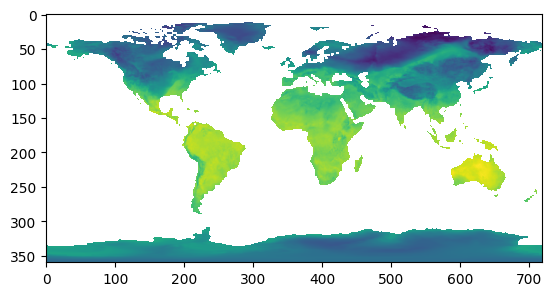

In [9]:
nc_files = glob(f'{DATADIR_TEMP}\\{1979}\\*.nc')
ds = xr.open_dataset(nc_files[0])

heatmap_tmp = np.rot90(ds.Tair[0].values, 2) # Rotate the heatmap 180 degrees
heatmap_tmp = np.fliplr(heatmap_tmp) # Flip the heatmap
    
# Calculate dpi to match the size of heatmap
# figsize = heatmap_tmp.shape[1]/float(160), heatmap_tmp.shape[0]/float(160)

print(heatmap_tmp.shape)

# Create the figure with specified size and tight layout
fig =plt.figure()
plt.imshow(heatmap_tmp)

In [6]:
def plot2rgb(heatmap: np.ndarray, dpi: int=100, figsize: tuple=None) -> np.ndarray:
    # Assuming 'heatmap' is a 2D array heatmap
    heatmap_tmp = np.rot90(heatmap, 2) # Rotate the heatmap 180 degrees
    heatmap_tmp = np.fliplr(heatmap_tmp) # Flip the heatmap
    
    # Calculate dpi to match the size of heatmap
    figsize = heatmap_tmp.shape[1]/float(dpi), heatmap_tmp.shape[0]/float(dpi)
    
    # Create the figure with specified size and tight layout
    fig =plt.figure(figsize=figsize, dpi=dpi)

    # Create the heatmap directly on the figure
    plt.imshow(heatmap_tmp)#, cmap='viridis')

    # Remove the axis
    plt.axis('off')

    # Adjust the subplot parameters for tight fitting
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)

    # Remove whitespaces from the margins
    plt.margins(0,0)

    # Draw the heatmap
    plt.draw()

    # Convert the heatmap to RGB array
    rgb_array = np.array(fig.canvas.renderer.buffer_rgba())

    # Remove the alpha channel generated by buffer_rgba method
    rgb_array = rgb_array[..., :3]

    # Transpose the array to match the shape required by PyTorch
    rgb_array = np.transpose(rgb_array, (2, 0, 1))

    # Close the figure
    plt.close(fig)

    return rgb_array

In [10]:
for i in range(len(years)):
    nc_files = glob(f'{DATADIR_TEMP}\\{years[i]}\\*.nc')
    for j in range(len(nc_files)):
        ds = xr.open_dataset(nc_files[j])
        for k in range(ds.Tair.shape[0]):
            if k == 0:
                ndarray_tmp = np.expand_dims(plot2rgb(ds.Tair[k].values), 0)
            else:
                ndarray_tmp = np.concatenate((ndarray_tmp, np.expand_dims(plot2rgb(ds.Tair[k].values), 0)), axis=0)
        averaged = np.expand_dims(np.round(np.mean(ndarray_tmp[0:], axis=0), 0).astype(int), 0)
        with open(f'{DATADIR_TEMP}\\{years[i]}-{months[j]}.npy', 'wb') as f:
            np.save(f, averaged)

In [6]:
for y in years:
    for m in months:
        with open(f'{DATADIR_TEMP}\\{y}-{m}.npy', 'rb') as f:
            checking_ndarray = np.load(f)
        averaged_tmp = np.round(np.mean(checking_ndarray, axis=0), 0).astype(int)
        with open(f'{DATADIR_TEMP}\\{y}-{m}.npy', 'wb') as f:
            np.save(f, averaged_tmp)        

(3, 360, 720)


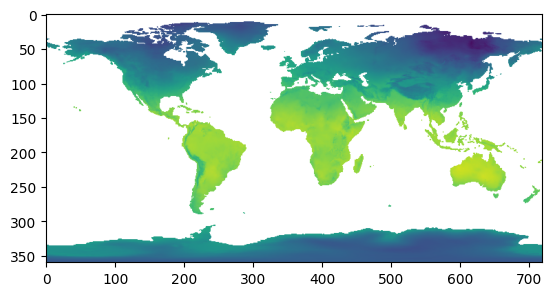

In [29]:
y = 1979
m = '01'

with open(f'{DATADIR_TEMP}\\{y}-{m}.npy', 'rb') as f:
    checking_ndarray = np.load(f)

print(checking_ndarray.shape)
plt.imshow(np.transpose(checking_ndarray, (1, 2, 0)))

### 4. Download precipitation data and unzip the downloaded data files

In [11]:
DATADIR_PRECIP = os.path.join(DATADIR, 'precipitation')
if not os.path.exists(DATADIR_PRECIP):
    os.makedirs(DATADIR_PRECIP)

In [12]:
c.retrieve(
    'satellite-precipitation',
    {
        'variable': 'all',
        'format': 'zip',
        'time_aggregation': 'monthly_mean',
        'year': years,
        'month': months
    },
    f'{DATADIR_PRECIP}\\download.zip' # download path
)

cmip6_zip_paths = glob(f'{DATADIR_PRECIP}\\*.zip')
for k in cmip6_zip_paths:
    with zipfile.ZipFile(k, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR_PRECIP}\\')

### 5. Convert images to ndarrays, average them 10-day window and save averaged ndarrays

(72, 144)


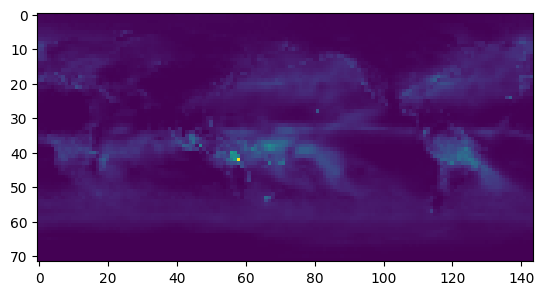

In [12]:
nc_files = glob(f'{DATADIR_PRECIP}\\*.nc')
ds = nc.Dataset(nc_files[0])

heatmap_tmp = np.rot90(ds['precip'][0], 2) # Rotate the heatmap 180 degrees
heatmap_tmp = np.fliplr(heatmap_tmp) # Flip the heatmap
    
# Calculate dpi to match the size of heatmap
# figsize = heatmap_tmp.shape[1]/float(160), heatmap_tmp.shape[0]/float(160)

print(heatmap_tmp.shape)

# Create the figure with specified size and tight layout
fig =plt.figure()
plt.imshow(heatmap_tmp)

In [10]:
def plot2rgb_precip(heatmap: np.ndarray, dpi: int=100) -> np.ndarray:
    # Assuming 'heatmap' is a 2D array heatmap
    heatmap_tmp = np.rot90(heatmap, 2) # Rotate the heatmap 180 degrees
    heatmap_tmp = np.fliplr(heatmap_tmp) # Flip the heatmap
    
    # Create the figure with specified size and tight layout
    fig =plt.figure(dpi=dpi)

    # Create the heatmap directly on the figure
    plt.imshow(heatmap_tmp)

    # Remove the axis
    plt.axis('off')

    # Adjust the subplot parameters for tight fitting
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)

    # Remove whitespaces from the margins
    plt.margins(0,0)

    # Draw the heatmap
    plt.draw()

    # Convert the heatmap to RGB array
    rgb_array = np.array(fig.canvas.renderer.buffer_rgba())

    # Remove the alpha channel generated by buffer_rgba method
    rgb_array = rgb_array[..., :3]

    # Transpose the array to match the shape required by PyTorch
    rgb_array = np.transpose(rgb_array, (2, 0, 1))

    # Close the figure
    plt.close(fig)

    return rgb_array

In [15]:
nc_files = glob(f'{DATADIR_PRECIP}\\*.nc')
for i in range(len(nc_files)):
    y, m = divmod(i, 12)
    ds = nc.Dataset(nc_files[i])
    precip_tmp = plot2rgb_precip(ds['precip'][0])
    with open(f'{DATADIR_PRECIP}\\{1979+y}-{months[m]}.npy', 'wb') as f:
        np.save(f, precip_tmp)

(3, 480, 640)


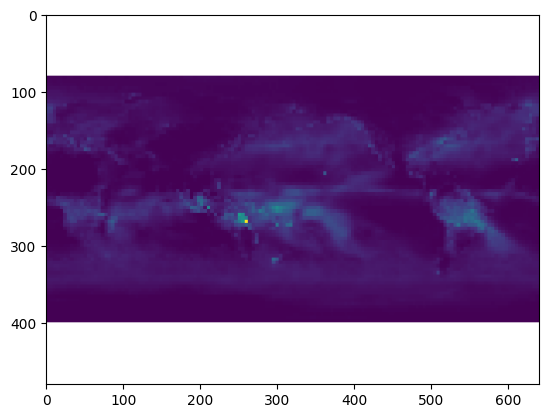

In [11]:
y = 1979
m = '01'

with open(f'{DATADIR_PRECIP}\\{y}-{m}.npy', 'rb') as f:
    checking_ndarray = np.load(f)

print(checking_ndarray.shape)

plt.imshow(np.transpose(checking_ndarray, (1, 2, 0)))